# 상추 생육상태 파악 CNN 모델 학습과정

### 🥬생육상태 파악 CNN 이란?
AI hub의 상추 데이터를 사용하여 잎채소의 생육상태를 판별하고  
성장 상태를 확인하는 CNN 모델을 학습했습니다.

팀에서 만든 Automation SamrtFarm 기기에서는 연결된 미니캠으로  
잎상추 채소의 수확 가능 여부를 파악하고, 디스플레이에 결과를 송출합니다.



   
### 목차
1. Preprocessing
2. Model Training
3. Result

## 1. Preprocessing

-1. 제작한 smartFarm 내부 설치된 웹캠에서 직접 데이터를 수집했습니다.
-2. AI hub의 상추 데이터를 이용했습니다.  

In [3]:
import os, re 
import random, math 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import warnings
from tensorflow.keras.models import load_model
import numpy as np # 데이터 배열 처리 라이브러리
import tensorflow as tf # 딥러닝 모델 형성 라이브러리

warnings.filterwarnings(action='ignore')

In [4]:
# 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + '\\oak\\train\\*\\*' 

#데이터 셋의 경우 업로드하지 않았습니다.

BATCH_SIZE = 8
EPOCHS = 10
train_filenames = tf.io.gfile.glob(TRAIN_PATH)


In [5]:
filenames = tf.io.gfile.glob(TRAIN_PATH)

train_size = math.floor(len(filenames)*0.8) #train 양의 0.8배
# 280 
test_size = math.floor(len(filenames)*0.9) #train 양의 0.8배

random.seed(8)
random.shuffle(filenames) #train + val 데이터를 뒤죽박죽 섞음


train_filenames = filenames[:train_size] #train은 합친 크기의 0.8 비율
val_filenames = filenames[train_size:test_size]   # val 은 합친 크기의 0.2 비율
test_filenames = filenames[test_size:]

print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

280
35
35


In [7]:
def count_print(data, str):
    '''
    data : "train" or "val" or "test"
    str : "baby" or "adult"
    
    각 경로의 데이터 수를 확인합니다.
    '''
    COUNT = len([filename for filename in (data + '_filename') if str in filename])
    
    print(f"{str}  images count in {data} set: {COUNT}")
    return None


_data = ['train', 'test', 'baby']
_str = ['adult', 'baby']

for data in _data:
    for str in _str:
        count_print(data,str)    

baby  images count in training set: 128
adult images count in training set: 152
baby  images count in val set: 18
adult images count in val set: 17
baby  images count in test set: 18
adult images count in test set: 17


In [9]:
# 경로들로 구성된 데이터들을 data 인스턴스로 변형, label 처리
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Labeling
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) #데이터 경로 끝에서 두번째 폴더 이름은
    return parts[-2] == "adult"  # adult와 baby

#이미지 균일화
def decode_img(img):
    #img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [11]:
for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 1)
Label:  True
Image shape:  (180, 180, 1)
Label:  False
Image shape:  (180, 180, 1)
Label:  True


In [13]:

# 제작한 함수 적용
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) #데이터를 섞어서 읽을 준비
    ds = ds.repeat() #데이터 한 번 불러오면 여러번 읽을 수 있게 함
    ds = ds.batch(BATCH_SIZE) # 베치화
    ds = ds.prefetch(buffer_size=AUTOTUNE) #다음 데이터를 준비해 효율화
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

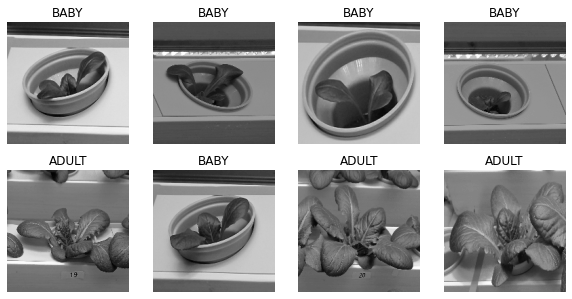

In [19]:
# 이미지 시각화
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(math.ceil(BATCH_SIZE/4),4,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        ##plt.imshow(image_batch[n]) RGB 쓰는 경우
        ## 다양한 채소의 일반화 적용을 위해 흑백 이미지로 변환학습 하였습니다.

        if label_batch[n]:
            plt.title("ADULT")
        else:
            plt.title("BABY")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [15]:
## 데이터 Augmentation 을 적용하였지만,
## 유의미한 개선이 드러나지 않아 사용하지 않았습니다.

# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

## 2. Model training

모델은 CNN 형태대로 구성했으며, 해당 논문을 참고했습니다.  
다만 흑백데이터에 맞춰서 채널을 수정하였습니다.

참고논문 : https://arxiv.org/pdf/1409.1556v6.pdf  




In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [19]:
TRAIN_IMG_COUNT = len([filename for filename in 'train_filename'])
VAL_IMG_COUNT = len([filename for filename in 'val_filename'])

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )

Epoch 1/10
35/35 [==============================] - 14s 397ms/step - loss: 0.5953 - accuracy: 0.7179 - precision: 0.7664 - recall: 0.6908 - val_loss: 0.7049 - val_accuracy: 0.4688 - val_precision: 0.4688 - val_recall: 1.0000
Epoch 2/10
35/35 [==============================] - 13s 379ms/step - loss: 0.2942 - accuracy: 0.8786 - precision: 0.8782 - recall: 0.9013 - val_loss: 0.7072 - val_accuracy: 0.5312 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 3/10
35/35 [==============================] - 14s 388ms/step - loss: 0.2759 - accuracy: 0.8714 - precision: 0.8766 - recall: 0.8882 - val_loss: 0.7693 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
35/35 [==============================] - 16s 462ms/step - loss: 0.1745 - accuracy: 0.9321 - precision: 0.9290 - recall: 0.9474 - val_loss: 0.8012 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
35/35 [==============================] - 17s 490ms/step - loss: 0.2429 - accuracy: 0.9143

학습한 모델은 아래와 같이
성장 여부 확률을 예측하고,  

성장 중인 잎채소는 baby,  
재배가 가능한 잎채소는 adult 를 반환합니다.


In [79]:
file_path_test = train_filenames[3]


def print_result(img):
    img = tf.io.read_file(img) # 이미지 읽기
    img = decode_img(img)
    img_array = np.expand_dims(img, axis=0)  # 4차원으로 확장
    result = model.predict(img_array)[0][0]
    print(result)

    if result >= 0.87240:
        return 'Adult'
    else:
        return 'baby'
print(print_result(file_path_test))


0.8721173
baby


## 3. Result
학습한 모델을 활용하기 위해서  
데이터를 저장하고 Express.js 환경에서 분석 후 반환하기 위해  
child processing 기법을 적용하였습니다.

In [75]:
from tensorflow.keras.models import save_model

# 모델 저장
model.save('plant-adult.h5')

In [4]:

# 모델 불러오기
loaded_model = load_model('plant-adult.h5')


def decode_img(img):
    IMAGE_SIZE = [180, 180]
    #img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


def print_result(img):
    img = tf.io.read_file(img) # 이미지로 받을 때
    img = decode_img(img)
    img_array = np.expand_dims(img, axis=0)  # 바로 받을 때 4차원으로 확장
    result = loaded_model.predict(img_array)[0][0]
    print(result)

    if result >= 0.87240:
        return 'Adult'
    else:
        return 'baby'

print_result('test.png')

0.8723382


'baby'